In [13]:
import torch
import os
from model import Model
from Dataset import Dataset
from torch import nn

In [6]:
BASE_DIR='../'
TRAIN_DIR=os.path.join(BASE_DIR,'DATA/Train')
TEST_DIR=os.path.join(BASE_DIR,'DATA/Test')
TRAIN_DIR,TEST_DIR
device='cuda'

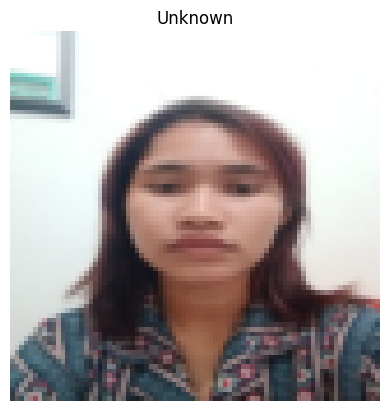

In [7]:
train_dataset=Dataset(path=TRAIN_DIR,batch_size=32,shuffle=True)
img,label=train_dataset.getSampleImage()

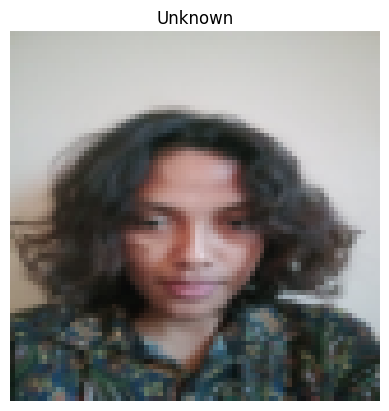

In [8]:
test_dataset=Dataset(path=TEST_DIR,batch_size=32,shuffle=False)
img,label=train_dataset.getSampleImage()

In [9]:
model=Model(input_shape=3,hidden_unit=64,output_shape=3).to(device)
model

Model(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=25600, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=3, bias=True)
    (4): Softmax(dim=1)
  )
)

In [10]:
img.shape

torch.Size([3, 80, 80])

In [11]:
output=model(img.unsqueeze(dim=0).to(device))
output

tensor([[0.3043, 0.3405, 0.3552]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [14]:
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device):
    # Set model into training mode
    model.train()
    # Set metric for evaluation
    train_loss,train_acc=0,0

    # training per batch
    for batch,(X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)

        y_pred=model(X)
        
        # calculate loss
        loss=loss_fn(y_pred,y)
        train_loss+=loss.item()

        # optimizer zero grad
        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)
    # accumulate loss and accuracy for each batch
    train_loss=train_loss/len(dataloader)
    train_acc=train_acc/len(dataloader)
    return train_loss,train_acc

In [15]:
def test_step(model:nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module,
              device:torch.device):
    
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            
            X,y=X.to(device),y.to(device)

            test_pred=model(X)
            loss=loss_fn(test_pred,y)
            test_loss+=loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [16]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,device=device)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Create model
model=Model(input_shape=3,hidden_unit=64,output_shape=3).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model, 
                        train_dataloader=train_dataset.dataloader,
                        test_dataloader=test_dataset.dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:48<07:13, 48.15s/it]

Epoch: 1 | train_loss: 0.8593 | train_acc: 0.7077 | test_loss: 0.8854 | test_acc: 0.6823


 20%|██        | 2/10 [01:30<05:58, 44.77s/it]

Epoch: 2 | train_loss: 0.6523 | train_acc: 0.9088 | test_loss: 0.7063 | test_acc: 0.8177


 30%|███       | 3/10 [02:13<05:08, 44.13s/it]

Epoch: 3 | train_loss: 0.6186 | train_acc: 0.9334 | test_loss: 0.7475 | test_acc: 0.7938


 40%|████      | 4/10 [02:55<04:19, 43.19s/it]

Epoch: 4 | train_loss: 0.5713 | train_acc: 0.9823 | test_loss: 0.7209 | test_acc: 0.8271


 50%|█████     | 5/10 [03:38<03:34, 42.89s/it]

Epoch: 5 | train_loss: 0.5613 | train_acc: 0.9918 | test_loss: 0.6981 | test_acc: 0.8490


 60%|██████    | 6/10 [04:21<02:52, 43.21s/it]

Epoch: 6 | train_loss: 0.5586 | train_acc: 0.9973 | test_loss: 0.7029 | test_acc: 0.8438


 70%|███████   | 7/10 [05:02<02:06, 42.33s/it]

Epoch: 7 | train_loss: 0.5566 | train_acc: 0.9973 | test_loss: 0.7427 | test_acc: 0.8115


 80%|████████  | 8/10 [05:43<01:23, 41.80s/it]

Epoch: 8 | train_loss: 0.5579 | train_acc: 0.9959 | test_loss: 0.7028 | test_acc: 0.8438


 90%|█████████ | 9/10 [06:23<00:41, 41.38s/it]

Epoch: 9 | train_loss: 0.5543 | train_acc: 0.9986 | test_loss: 0.7031 | test_acc: 0.8438


100%|██████████| 10/10 [07:04<00:00, 42.41s/it]

Epoch: 10 | train_loss: 0.5521 | train_acc: 1.0000 | test_loss: 0.7223 | test_acc: 0.8302
Total training time: 424.141 seconds


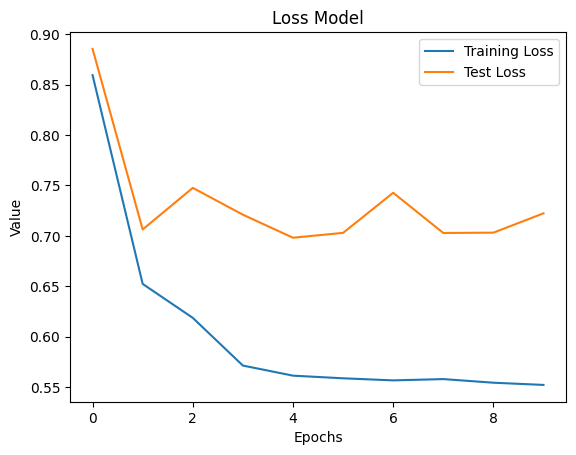

In [20]:
import matplotlib.pyplot as plt

plt.plot(model_0_results['train_loss'])
plt.plot(model_0_results['test_loss'])
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Loss Model')
plt.legend(['Training Loss','Test Loss'])
plt.show()

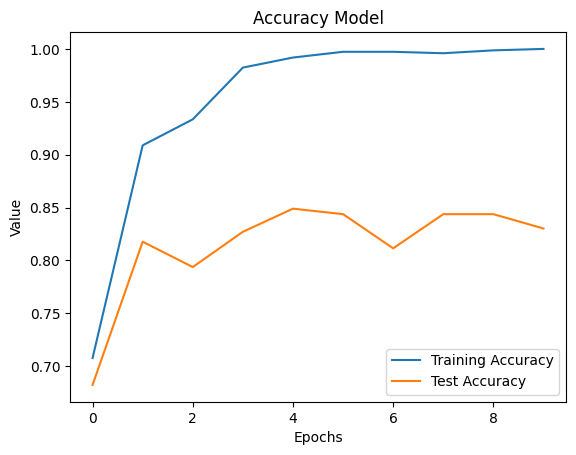

In [21]:
import matplotlib.pyplot as plt

plt.plot(model_0_results['train_acc'])
plt.plot(model_0_results['test_acc'])
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Accuracy Model')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.show()

In [22]:
import cv2 as cv
import numpy as np

In [23]:
model.eval()
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
# define video capture -> load video dari webcam
video_capture = cv.VideoCapture(0)
while True:
    isTrue,frame=video_capture.read()
    frame_rgb=cv.cvtColor(frame,cv.COLOR_BGR2RGB)
    frame_resized=cv.resize(frame_rgb,dsize=(80,80))
    frame_tensor = torch.from_numpy(frame_resized).float().permute(2,0,1).to(device)
    frame_tensor=frame_tensor.unsqueeze(dim=0)
    with torch.inference_mode():
        predictions = model(frame_tensor)
    label=predictions.squeeze()
    label=torch.argmax(label)
    print(train_dataset.classes[label])
    faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv.putText(frame,str(train_dataset.classes[label]),org=(x, y-10),fontFace=cv.FONT_HERSHEY_SIMPLEX,fontScale=0.9,color=(255,0,0),thickness=2,lineType=cv.LINE_AA)
    cv.imshow('Video', frame)
            # Exit loop if 'q' is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
        # Destroy window when the real time predictions end
cv.destroyAllWindows()

Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Dyah
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
